## Modelling and evaluation

### Addressing the business question no. 2:
* Can we tell if an uploaded (previously unseen) image was taken for a 'Healthy', 'Bleached' or 'Dead' coral.

### Inputs

* inputs/corals-dataset/Healthy
* inputs/corals-dataset/Bleached
* inputs/corals-dataset/Dead
* outputs/v1/image_shape.pkl

### Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

### Import packages

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Define working directory

In [16]:
cwd = os.getcwd()
os.chdir('/workspace/corals_health')
print("You set a new current directory")
work_dir = os.getcwd()
work_dir

You set a new current directory


'/workspace/corals_health'

### Set input directories

In [17]:
my_data_dir = 'inputs/corals-dataset/Dataset'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')
print(train_path)
print(val_path)
print(test_path)

inputs/corals-dataset/Dataset/train
inputs/corals-dataset/Dataset/validation
inputs/corals-dataset/Dataset/test


### Set output directories

In [18]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels

In [19]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)
print(type(labels))

Project Labels: ['Bleached', 'Dead', 'Healthy']
<class 'list'>


### Set image shape

In [20]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(227, 227, 3)

### Number of images in train, test and validation data

* train - Bleached: 503 images
* train - Dead: 105 images
* train - Healthy: 498 images
* validation - Bleached: 72 images
* validation - Dead: 15 images
* validation - Healthy: 71 images
* test - Bleached: 145 images
* test - Dead: 30 images
* test - Healthy: 143 images




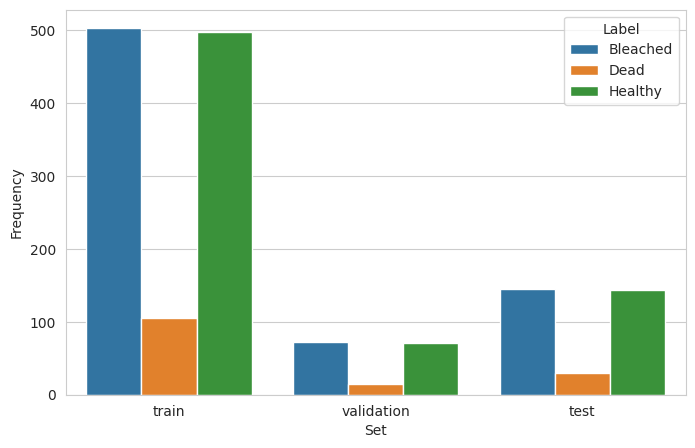

In [21]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Data augmentation

### ImageDataGenerator

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* Initialize ImageDataGenerator

In [23]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* Augment training dataset

In [24]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 1106 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

* Augment validation dataset

In [25]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 158 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

* Aurment test dataset

In [26]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 318 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

#### Plot augmented training image

(20, 227, 227, 3)


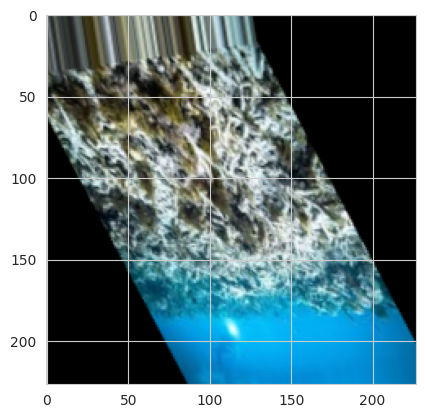

(20, 227, 227, 3)


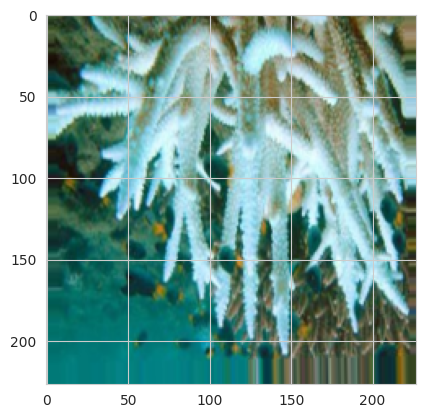

(20, 227, 227, 3)


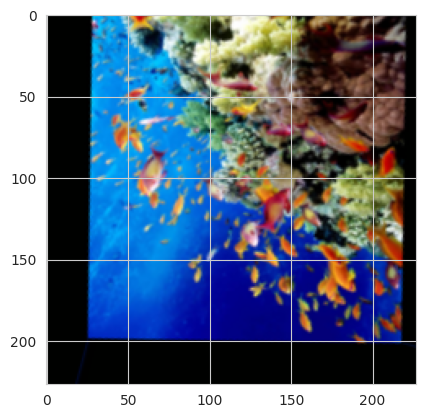

In [28]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented validation image

(20, 227, 227, 3)


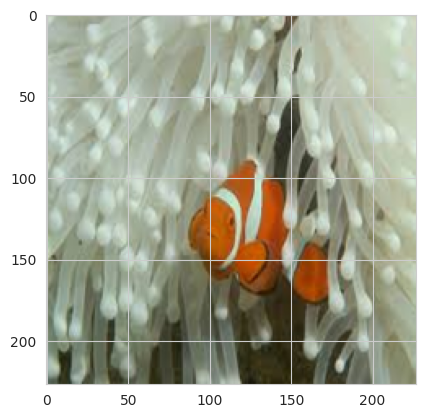

(20, 227, 227, 3)


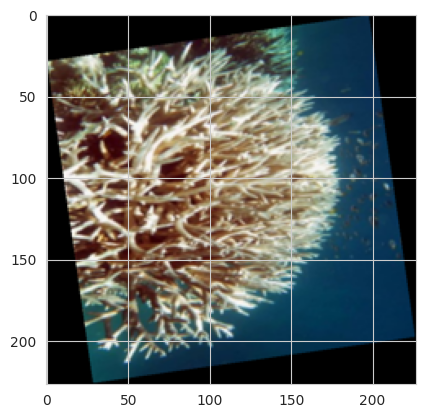

(20, 227, 227, 3)


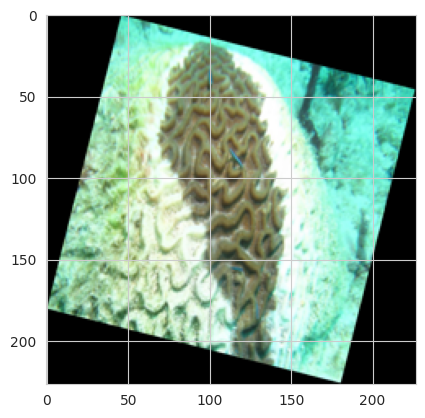

In [29]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented test image

(20, 227, 227, 3)


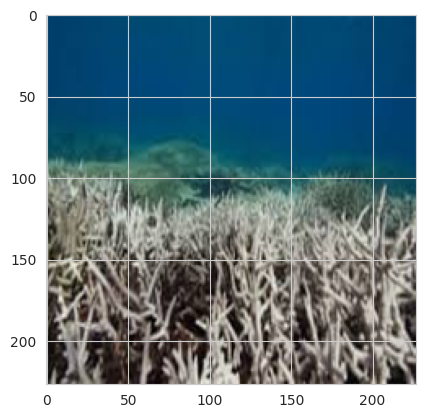

(20, 227, 227, 3)


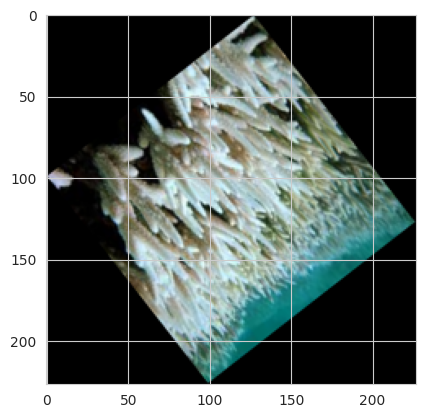

(20, 227, 227, 3)


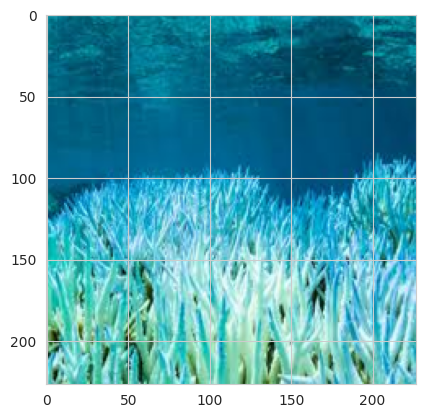

In [30]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [31]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

<hr>


## Building the model
<hr>

### Import model packages

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical

#### Model

In [33]:
def create_tf_model():
    """
    Function that will create, compile and return a sequential model for classifying
    three types of images of corals ('healthy', 'bleached' and 'dead')
    """
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

#### Model summary

In [39]:
image_shape = (227, 227, 3)
create_tf_model().summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 225, 225, 32)      608       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 53, 53, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 43264)            

#### Define early stop

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for model training

In [45]:
train_set.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [42]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25


ValueError: in user code:

    /workspace/.pip-modules/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /workspace/.pip-modules/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /workspace/.pip-modules/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /workspace/.pip-modules/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /workspace/.pip-modules/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /workspace/.pip-modules/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /workspace/.pip-modules/lib/python3.8/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /workspace/.pip-modules/lib/python3.8/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /workspace/.pip-modules/lib/python3.8/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /workspace/.pip-modules/lib/python3.8/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /workspace/.pip-modules/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /workspace/.pip-modules/lib/python3.8/site-packages/keras/losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    /workspace/.pip-modules/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /workspace/.pip-modules/lib/python3.8/site-packages/keras/backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /workspace/.pip-modules/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible
